In [20]:
import numpy as np
from skimage.transform import resize

#make a function that given a volume returns the center slice in x,y and z
def get_center_slices(vol):
    x,y,z = vol.shape
    return vol[(x-1)//2,:,:], vol[:,(y-1)//2,:], vol[:,:,(z-1)//2]

def resize2_32(slice):
    return resize(slice, (32,32), anti_aliasing=True)

def resize2_224(slice):
    return resize(slice, (224,224), anti_aliasing=True)

def get_spd(acts,type="gramm"):
    h,w,d = acts.shape
    vect_acts = acts.reshape(h*w,d)
    if type == "gramm":
        spd = vect_acts.T@vect_acts
    elif type == "corr":
        spd = np.corrcoef(vect_acts.T)
    elif type == "cov":
        spd = np.cov(vect_acts.T)
    return spd

def get_bbox(mask, ratio=0.2):
    """
    Return bounding box [z_min:z_max, y_min:y_max, x_min:x_max] where mask>0,
    expanded by a given ratio (e.g., ratio=0.2 means 20% larger per dimension).
    """
    coords = np.argwhere(mask > 0)
    zmin, ymin, xmin = coords.min(axis=0)
    zmax, ymax, xmax = coords.max(axis=0) + 1

    # Compute current size
    dz, dy, dx = zmax - zmin, ymax - ymin, xmax - xmin

    # Expand size by ratio on both sides
    expand_z = int(dz * ratio / 2)
    expand_y = int(dy * ratio / 2)
    expand_x = int(dx * ratio / 2)

    # Apply expansion, making sure indices are valid
    zmin = max(0, zmin - expand_z)
    ymin = max(0, ymin - expand_y)
    xmin = max(0, xmin - expand_x)

    zmax = min(mask.shape[0], zmax + expand_z)
    ymax = min(mask.shape[1], ymax + expand_y)
    xmax = min(mask.shape[2], xmax + expand_x)

    return (zmin, zmax, ymin, ymax, xmin, xmax)


def crop_volume(vol, zrange, yrange, xrange):
    return vol[zrange[0]:zrange[1], yrange[0]:yrange[1], xrange[0]:xrange[1]]


def split_prostate_into_sextants(mask, bbox_ratio=0.1):
    """Divide prostate mask into 6 sextants and return list of index ranges."""
    zmin, zmax, ymin, ymax, xmin, xmax = get_bbox(mask, ratio=bbox_ratio)

    #Print shape of the bounding box
    BBOX = (zmax - zmin, ymax - ymin, xmax - xmin)
    print(f"BBOX shape: {BBOX}")

    z_thirds = np.linspace(zmin, zmax, 4, dtype=int)  # 3 equal parts along z
    x_mid = (xmin + xmax) // 2  # midline for left/right division

    sextants = []
    for i in range(3):  # base, mid, apex
        for j in range(2):  # left/right
            zrange = (z_thirds[i], z_thirds[i+1])
            yrange = (ymin, ymax)
            if j == 0:  # left
                xrange = (xmin, x_mid)
            else:       # right
                xrange = (x_mid, xmax)
            sextants.append((zrange, yrange, xrange))
    return sextants


In [17]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

#Load the model
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(32,32,3))

#Get the first pooling layer
model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block1_conv2').output)
model.summary()

2025-11-11 13:39:07.682784: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,720 (151.25 KB)

 Trainable params: 38,720 (151.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
import os, json
import numpy as np
import SimpleITK as sitk
from time import sleep

PATH_IMAGES = '/Datasets/PICAI_olmos/Task2308_prep_picai_baseline/imagesTr' 
PATH_SEG = '/Datasets/PICAI_olmos/Task2308_prep_picai_baseline/labelsTr'
PATH_GLAND = '/Datasets/PICAI_olmos/Task2308_prep_picai_baseline/labelsTr_bosma'
PATH_JSON_INFO = '/Datasets/PICAI_olmos/info-12x32x32.json'
SAVE_PATH = '/Datasets/PICAI_sextants'

os.makedirs(SAVE_PATH, exist_ok=True)

with open(PATH_JSON_INFO, 'r') as f:
    info = json.load(f)



# ---- MAIN LOOP ----
for i, name in enumerate(info.keys()):
    print(f"Processing {i+1}/{len(info)}: {name}")

    # Load volumes
    t2 = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_IMAGES, f'{name}_0000.nii.gz')))
    adc = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_IMAGES, f'{name}_0001.nii.gz')))
    bval = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_IMAGES, f'{name}_0002.nii.gz')))
    gland_mask = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_GLAND, f'{name}.nii.gz')))

    # Get sextants
    sextants = split_prostate_into_sextants(gland_mask, bbox_ratio=0.1)

    for idx, (zrange, yrange, xrange) in enumerate(sextants):
        t2_patch = crop_volume(t2, zrange, yrange, xrange)
        adc_patch = crop_volume(adc, zrange, yrange, xrange)
        bval_patch = crop_volume(bval, zrange, yrange, xrange)
        # Print shapes for debugging
        print(f"  Sextant {idx}: T2 {t2_patch.shape}, ADC {adc_patch.shape}, BVAL {bval_patch.shape}")
        

        # Save each modality
        # np.save(os.path.join(SAVE_PATH, f'{name}_sextant{idx}_0000.npy'), t2_patch)
        # np.save(os.path.join(SAVE_PATH, f'{name}_sextant{idx}_0001.npy'), adc_patch)
        # np.save(os.path.join(SAVE_PATH, f'{name}_sextant{idx}_0002.npy'), bval_patch)
    break
    print(f" → Saved 6 sextants for {name}")
    sleep(0.05)


Processing 1/1295: 11107_1001130
BBOX shape: (np.int64(23), np.int64(110), np.int64(117))
  Sextant 0: T2 (7, 110, 58), ADC (7, 110, 58), BVAL (7, 110, 58)
  Sextant 1: T2 (7, 110, 59), ADC (7, 110, 59), BVAL (7, 110, 59)
  Sextant 2: T2 (8, 110, 58), ADC (8, 110, 58), BVAL (8, 110, 58)
  Sextant 3: T2 (8, 110, 59), ADC (8, 110, 59), BVAL (8, 110, 59)
  Sextant 4: T2 (8, 110, 58), ADC (8, 110, 58), BVAL (8, 110, 58)
  Sextant 5: T2 (8, 110, 59), ADC (8, 110, 59), BVAL (8, 110, 59)


In [10]:
import os, json
import numpy as np
import SimpleITK as sitk
from time import sleep

PATH_IMAGES = '/Datasets/PICAI_olmos/Task2308_prep_picai_baseline/imagesTr' 
PATH_SEG = '/Datasets/PICAI_olmos/Task2308_prep_picai_baseline/labelsTr'          # lesion segmentation
PATH_GLAND = '/Datasets/PICAI_olmos/Task2308_prep_picai_baseline/labelsTr_bosma'  # prostate gland
PATH_JSON_INFO = '/Datasets/PICAI_olmos/info-12x32x32.json'
SAVE_PATH = '/Datasets/PICAI_sextants'

os.makedirs(SAVE_PATH, exist_ok=True)

with open(PATH_JSON_INFO, 'r') as f:
    info = json.load(f)

def get_bbox(mask, ratio=0.2):
    """
    Return bounding box [z_min:z_max, y_min:y_max, x_min:x_max] where mask>0,
    expanded by a given ratio (e.g., ratio=0.2 means 20% larger per dimension).
    """
    coords = np.argwhere(mask > 0)
    zmin, ymin, xmin = coords.min(axis=0)
    zmax, ymax, xmax = coords.max(axis=0) + 1

    # Compute current size
    dz, dy, dx = zmax - zmin, ymax - ymin, xmax - xmin

    # Expand size by ratio on both sides
    expand_z = int(dz * ratio / 2)
    expand_y = int(dy * ratio / 2)
    expand_x = int(dx * ratio / 2)

    # Apply expansion, making sure indices are valid
    zmin = max(0, zmin - expand_z)
    ymin = max(0, ymin - expand_y)
    xmin = max(0, xmin - expand_x)

    zmax = min(mask.shape[0], zmax + expand_z)
    ymax = min(mask.shape[1], ymax + expand_y)
    xmax = min(mask.shape[2], xmax + expand_x)

    return (zmin, zmax, ymin, ymax, xmin, xmax)


def crop_volume(vol, zrange, yrange, xrange):
    return vol[zrange[0]:zrange[1], yrange[0]:yrange[1], xrange[0]:xrange[1]]


import numpy as np
import math

def split_prostate_into_sextants(mask, bbox_ratio=0.1):
    """
    Divide prostate mask into 6 sextants where every sextant has 
    IDENTICAL dimensions (x, y, z).
    """
    # 1. Get the tight bounding box of the prostate
    zmin, zmax, ymin, ymax, xmin, xmax = get_bbox(mask, ratio=bbox_ratio)

    # 2. Calculate the total lengths of the ROI
    len_z = zmax - zmin
    len_y = ymax - ymin
    len_x = xmax - xmin

    # 3. Determine the fixed block size for every sextant.
    # We use ceil to ensure we don't cut off data. The blocks may extend slightly
    # beyond the original ROI, which is preferable to losing data.
    # Z is split into 3, X is split into 2.
    block_z = math.ceil(len_z / 3)
    block_x = math.ceil(len_x / 2)
    block_y = len_y  # Y is usually kept full (Coronal view)

    sextants = []
    
    # 4. Generate ranges using the fixed block sizes
    # Structure: 3 levels (Base, Mid, Apex) x 2 sides (Right, Left)
    for i in range(3):      # i=0 (Base), i=1 (Mid), i=2 (Apex)
        for j in range(2):  # j=0 (Right/Left depending on view), j=1 (Opposite)
            
            # Calculate Z range
            z_start = zmin + (i * block_z)
            z_end = z_start + block_z
            
            # Calculate X range
            # Note: j=0 covers the first half, j=1 covers the second half
            x_start = xmin + (j * block_x)
            x_end = x_start + block_x
            
            # Y range is constant
            y_start = ymin
            y_end = ymax

            # Store the ranges (Start, Stop)
            # These ranges are guaranteed to have size: (block_z, block_y, block_x)
            sextants.append({
                'z': (z_start, z_end),
                'y': (y_start, y_end),
                'x': (x_start, x_end),
                'label': f"Sextant_{i}_{j}"
            })
            
    return sextants, (block_z, block_y, block_x)

# --- Helper to safely extract these crops ---
def extract_sextant_crop(image, ranges):
    """
    Extracts the sextant from the image.
    Handles out-of-bounds errors by padding if the fixed range exceeds image dims.
    """
    (zs, ze), (ys, ye), (xs, xe) = ranges['z'], ranges['y'], ranges['x']
    
    # Create the container with the fixed shape
    depth = ze - zs
    height = ye - ys
    width = xe - xs
    crop = np.zeros((depth, height, width), dtype=image.dtype)

    # Calculate valid intersection with the image
    img_d, img_h, img_w = image.shape
    
    # Source indices (clamped to image bounds)
    src_zs, src_ze = max(0, zs), min(img_d, ze)
    src_ys, src_ye = max(0, ys), min(img_h, ye)
    src_xs, src_xe = max(0, xs), min(img_w, xe)

    # Destination indices (where to paste in the fixed crop)
    dst_zs = src_zs - zs
    dst_ze = dst_zs + (src_ze - src_zs)
    
    dst_ys = src_ys - ys
    dst_ye = dst_ys + (src_ye - src_ys)
    
    dst_xs = src_xs - xs
    dst_xe = dst_xs + (src_xe - src_xs)

    # Copy data
    if (src_ze > src_zs) and (src_ye > src_ys) and (src_xe > src_xs):
        crop[dst_zs:dst_ze, dst_ys:dst_ye, dst_xs:dst_xe] = \
            image[src_zs:src_ze, src_ys:src_ye, src_xs:src_xe]
            
    return crop


# ---- MAIN LOOP ----
for i, name in enumerate(info.keys()):
    print(f"Processing {i+1}/{len(info)}: {name}")

    # Load prostate gland and lesion segmentation
    gland_mask = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_GLAND, f'{name}.nii.gz')))
    lesion_mask = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_SEG, f'{name}.nii.gz')))

    sextants = split_prostate_into_sextants(gland_mask, bbox_ratio=0.1)

    total_lesion_voxels = np.sum(lesion_mask > 0)
    sextant_percentages = {}

    if total_lesion_voxels == 0:
        print("  ⚠ No lesion found")
        sextant_percentages = {f"sextant{idx}": 0.0 for idx in range(6)}
    else:
        for idx, (zrange, yrange, xrange) in enumerate(sextants):
            lesion_crop = crop_volume(lesion_mask, zrange, yrange, xrange)
            sextant_voxels = np.sum(lesion_crop > 0)
            percentage = 100 * sextant_voxels / total_lesion_voxels
            sextant_percentages[f"sextant{idx}"] = round(percentage, 3)

            print(f"  Sextant {idx}: {percentage:.2f}% of lesion volume")

    # Store results
    info[name]["sextant_lesion_percentage"] = sextant_percentages

    sleep(0.05)

# ---- Save updated info ----
OUTPUT_JSON = '/Datasets/PICAI_olmos/info_sextant_lesion_percentages.json'
with open(OUTPUT_JSON, 'w') as f:
    json.dump(info, f, indent=2)

print(f"\n✅ Updated info saved to {OUTPUT_JSON}")


Processing 1/1295: 11107_1001130
  ⚠ No lesion found
Processing 2/1295: 10078_1000078
  Sextant 0: 0.00% of lesion volume
  Sextant 1: 0.00% of lesion volume
  Sextant 2: 98.64% of lesion volume
  Sextant 3: 0.00% of lesion volume
  Sextant 4: 0.00% of lesion volume
  Sextant 5: 0.00% of lesion volume
Processing 3/1295: 11244_1001267
  ⚠ No lesion found
Processing 4/1295: 11024_1001044
  ⚠ No lesion found
Processing 5/1295: 10798_1000814
  Sextant 0: 11.57% of lesion volume
  Sextant 1: 3.57% of lesion volume
  Sextant 2: 27.41% of lesion volume
  Sextant 3: 16.49% of lesion volume
  Sextant 4: 21.79% of lesion volume
  Sextant 5: 18.44% of lesion volume
Processing 6/1295: 10604_1000618
  Sextant 0: 0.00% of lesion volume
  Sextant 1: 0.00% of lesion volume
  Sextant 2: 0.00% of lesion volume
  Sextant 3: 100.00% of lesion volume
  Sextant 4: 0.00% of lesion volume
  Sextant 5: 0.00% of lesion volume
Processing 7/1295: 10716_1000732
  ⚠ No lesion found
Processing 8/1295: 11357_1001380


In [22]:
info['10078_1000078']

{'mri_date': '2012-06-30',
 'patient_age': 51,
 'psa': 7.6,
 'psad': 0.14,
 'prostate_volume': 56.0,
 'histopath_type': 'MRBx',
 'lesion_GS': '4+4',
 'lesion_ISUP': '4',
 'case_ISUP': 4,
 'case_csPCa': 'YES',
 'centroid': [116, 289, 11],
 'path_id': '/data/jaolmosr/2023_prostate_deep_representations/data_temporal/PICAIDataset/size-12x32x32/10078_1000078.npy',
 'label': 1}


--- Lesion Sextant Coverage Summary ---
Total cases: 1295
Cases with no lesion: 1076
Cases with < 90% lesion in sextants: 11
Percentage below threshold: 5.02%

Mean total lesion coverage: 73.12%
Median total lesion coverage: 74.13%


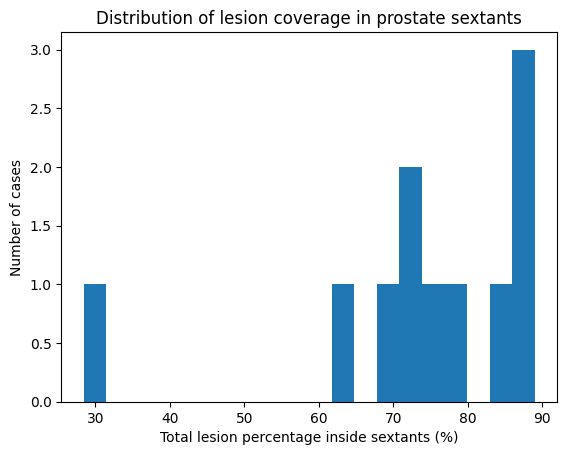

In [13]:

total_cases = len(info)
below_thresh = 0
no_lesion = 0
lesion_coverages = []

# Loop over all cases
for name, data in info.items():
    sextant_data = data.get("sextant_lesion_percentage", None)
    if sextant_data is None:
        continue

    # Sum of all sextant lesion percentages
    total_coverage = np.sum(list(sextant_data.values()))
    

    if total_coverage == 0:
        no_lesion += 1
    elif total_coverage < THRESHOLD:
        below_thresh += 1
        lesion_coverages.append(total_coverage)

# Compute summary stats
lesion_coverages = np.array(lesion_coverages)
mean_coverage = np.mean(lesion_coverages)
median_coverage = np.median(lesion_coverages)

print(f"\n--- Lesion Sextant Coverage Summary ---")
print(f"Total cases: {total_cases}")
print(f"Cases with no lesion: {no_lesion}")
print(f"Cases with < {THRESHOLD}% lesion in sextants: {below_thresh}")
print(f"Percentage below threshold: {100 * below_thresh / (total_cases - no_lesion):.2f}%")
print(f"\nMean total lesion coverage: {mean_coverage:.2f}%")
print(f"Median total lesion coverage: {median_coverage:.2f}%")

# Optional: histogram of lesion coverage distribution
import matplotlib.pyplot as plt

plt.hist(lesion_coverages, bins=20)
plt.xlabel("Total lesion percentage inside sextants (%)")
plt.ylabel("Number of cases")
plt.title("Distribution of lesion coverage in prostate sextants")
plt.show()

In [29]:
path_folds = '/Datasets/PICAI_olmos/picai_folds_indexes.json'
with open(path_folds, 'r') as f:
    folds = json.load(f)
folds.keys()

dict_keys(['Fold_0_train', 'Fold_1_train', 'Fold_2_train', 'Fold_3_train', 'Fold_4_train', 'Fold_0_val', 'Fold_1_val', 'Fold_2_val', 'Fold_3_val', 'Fold_4_val'])

In [ ]:
import os
import json
import math
import numpy as np
import SimpleITK as sitk
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tqdm import tqdm
from time import sleep

# --- CONFIGURATION ---
PATH_IMAGES = '/Datasets/PICAI_olmos/Task2308_prep_picai_baseline/imagesTr' 
PATH_SEG = '/Datasets/PICAI_olmos/Task2308_prep_picai_baseline/labelsTr'
PATH_GLAND = '/Datasets/PICAI_olmos/Task2308_prep_picai_baseline/labelsTr_bosma'
PATH_JSON_INFO = '/Datasets/PICAI_olmos/info-12x32x32.json'
SAVE_PATH = '/Datasets/PICAI_sextants'

os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(os.path.join(SAVE_PATH, 'covs'), exist_ok=True)

# --- HELPER FUNCTIONS ---

def get_bbox(mask, ratio=0.1):
    coords = np.argwhere(mask > 0)
    if coords.size == 0:
        return 0, mask.shape[0], 0, mask.shape[1], 0, mask.shape[2]
    z_min, y_min, x_min = coords.min(axis=0)
    z_max, y_max, x_max = coords.max(axis=0)
    
    d, h, w = mask.shape
    margin_z, margin_y, margin_x = [int((high - low) * ratio) for low, high in [(z_min, z_max), (y_min, y_max), (x_min, x_max)]]

    return (max(0, z_min - margin_z), min(d, z_max + margin_z),
            max(0, y_min - margin_y), min(h, y_max + margin_y),
            max(0, x_min - margin_x), min(w, x_max + margin_x))

def split_prostate_into_sextants_uniform(mask, bbox_ratio=0.1):
    zmin, zmax, ymin, ymax, xmin, xmax = get_bbox(mask, ratio=bbox_ratio)
    len_z, len_x = zmax - zmin, xmax - xmin
    block_z, block_x = math.ceil(len_z / 3), math.ceil(len_x / 2)
    
    sextants = []
    for i in range(3):
        for j in range(2):
            sextants.append({
                'z': (zmin + i*block_z, zmin + (i+1)*block_z),
                'y': (ymin, ymax),
                'x': (xmin + j*block_x, xmin + (j+1)*block_x),
                'id': f"sextant_{i}_{j}"
            })
    return sextants

def extract_sextant_crop(image, ranges):
    (zs, ze), (ys, ye), (xs, xe) = ranges['z'], ranges['y'], ranges['x']
    crop = np.zeros((ze - zs, ye - ys, xe - xs), dtype=image.dtype)
    
    src_zs, src_ze = max(0, zs), min(image.shape[0], ze)
    src_ys, src_ye = max(0, ys), min(image.shape[1], ye)
    src_xs, src_xe = max(0, xs), min(image.shape[2], xe)

    if src_ze > src_zs and src_ye > src_ys and src_xe > src_xs:
        crop[src_zs-zs : src_zs-zs+(src_ze-src_zs), 
             src_ys-ys : src_ys-ys+(src_ye-src_ys), 
             src_xs-xs : src_xs-xs+(src_xe-src_xs)] = image[src_zs:src_ze, src_ys:src_ye, src_xs:src_xe]
    return crop

def compute_covariance(matrix):
    # Shape: (Features, Observations)
    if matrix.shape[1] < 2: return np.zeros((matrix.shape[0], matrix.shape[0]))
    centered = matrix - np.mean(matrix, axis=1, keepdims=True)
    return np.matmul(centered, centered.T) / (matrix.shape[1] - 1)

def get_spd(cov_matrix, epsilon=1e-5):
    trace = np.trace(cov_matrix)
    return cov_matrix + (np.eye(cov_matrix.shape[0]) * epsilon * (trace if trace > 0 else 1.0))

# --- MODEL SETUP (Dynamic Input) ---
print("Loading VGG19 Model...")
# NOTE: input_shape=(None, None, 3) allows variable image sizes!
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(None, None, 3))
feature_extractor = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block1_conv2').output)

# --- MAIN LOOP ---
with open(PATH_JSON_INFO, 'r') as f:
    info = json.load(f)

new_dataset_info = []

for idx, (patient_id, patient_data) in enumerate(tqdm(info.items())):
    try:
        # Load and Normalize
        t2 = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_IMAGES, f'{patient_id}_0000.nii.gz')))
        adc = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_IMAGES, f'{patient_id}_0001.nii.gz')))
        bval = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_IMAGES, f'{patient_id}_0002.nii.gz')))
        gland_mask = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_GLAND, f'{patient_id}.nii.gz')))
        lesion_mask = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_SEG, f'{patient_id}.nii.gz')))
        
        # Standardize full volume first
        t2 = (t2 - t2.mean()) / (t2.std() + 1e-8)
        adc = (adc - adc.mean()) / (adc.std() + 1e-8)
        bval = (bval - bval.mean()) / (bval.std() + 1e-8)

        sextants = split_prostate_into_sextants_uniform(gland_mask, bbox_ratio=0.1)

        for sextant_idx, ranges in enumerate(sextants):
            # Extract Raw Crops (Original Size)
            c_t2 = extract_sextant_crop(t2, ranges)
            c_adc = extract_sextant_crop(adc, ranges)
            c_bval = extract_sextant_crop(bval, ranges)
            c_lesion = extract_sextant_crop(lesion_mask, ranges)
            
            # --- INFO UPDATE ---
            lesion_pct = (np.count_nonzero(c_lesion) / c_lesion.size * 100) if c_lesion.size > 0 else 0.0
            s_info = patient_data.copy()
            s_info.update({'sextant_id': ranges['id'], 'lesion_percentage': lesion_pct})
            
            # --- FEATURE EXTRACTION ---
            features_collector = []
            depth, h, w = c_t2.shape
            
            # Skip if volume is effectively empty (e.g., 0 depth)
            if depth > 0 and h > 0 and w > 0:
                for z in range(depth):
                    # Stack modalities for this slice: (H, W) -> (H, W, 3)
                    # We create 3 separate RGB images (one per modality) to pass to VGG
                    # because we want to extract features for T2, ADC, BVAL separately 
                    # but using the same VGG weights.
                    
                    # Prepare Batch: [T2_RGB, ADC_RGB, BVAL_RGB]
                    batch_in = np.stack([
                        np.repeat(c_t2[z][:, :, np.newaxis], 3, axis=2),
                        np.repeat(c_adc[z][:, :, np.newaxis], 3, axis=2),
                        np.repeat(c_bval[z][:, :, np.newaxis], 3, axis=2)
                    ], axis=0) # Shape: (3, H, W, 3)
                    
                    # Predict features
                    # Output shape: (3, H, W, 64) -> Dimensions H,W preserved
                    activations = feature_extractor.predict(batch_in, verbose=0)
                    features_collector.append(activations)

                # Stack all Z slices -> (Depth, Modalities=3, H, W, Feats=64)
                full_feats = np.stack(features_collector, axis=0)
                
                # Transpose to: (Modalities, Feats, Depth, H, W)
                full_feats = full_feats.transpose(1, 4, 0, 2, 3)
                
                # Flatten spatial dimensions into observations
                # Reshape to (192, N_observations)
                features_flat = full_feats.reshape(3 * 64, -1)
                
                cov_matrix = compute_covariance(features_flat)
                spd_matrix = get_spd(cov_matrix)
            else:
                spd_matrix = np.eye(192) # Fallback for empty crops
            
            # --- SAVE ---
            file_name = f"{patient_id}_{ranges['id']}_cov.npy"
            sleep(0.01)
            save_full = os.path.join(SAVE_PATH, 'covs_vgg19', file_name)
            np.save(save_full, spd_matrix)
            
            s_info['cov_path'] = save_full
            s_info['patient_id'] = patient_id
            new_dataset_info.append(s_info)

    except Exception as e:
        print(f"Skipping {patient_id} due to error: {e}")

with open(os.path.join(SAVE_PATH, 'info_sextants.json'), 'w') as f:
    json.dump(new_dataset_info, f, indent=4)

Loading VGG19 Model...


W0000 00:00:1765156848.102363    2308 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


  5%|▌         | 71/1295 [03:54<1:21:48,  4.01s/it]

In [2]:
!pip install tqdm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [9]:
import os
import json
from time import sleep
import math
import numpy as np
import SimpleITK as sitk
import torch
from transformers import AutoImageProcessor, AutoModel
from tqdm import tqdm

# --- CONFIGURATION ---
PATH_IMAGES = '/Datasets/PICAI_olmos/Task2308_prep_picai_baseline/imagesTr' 
PATH_SEG = '/Datasets/PICAI_olmos/Task2308_prep_picai_baseline/labelsTr'
PATH_GLAND = '/Datasets/PICAI_olmos/Task2308_prep_picai_baseline/labelsTr_bosma'
PATH_JSON_INFO = '/Datasets/PICAI_olmos/info-12x32x32.json'
SAVE_PATH = '/Datasets/PICAI_sextants_dinov2'

# DINOv2 Model Choice ('small' is 384 dim, 'base' is 768 dim)
MODEL_NAME = 'facebook/dinov2-small'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Dimensionality Reduction Settings
TARGET_DIM = 192  # We will project the 1152x1152 matrix down to 192x192

os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(os.path.join(SAVE_PATH, 'covs'), exist_ok=True)

# --- HELPER FUNCTIONS ---

def normalize_to_uint8(vol):
    """
    Normalizes a volume to 0-255 range and converts to uint8.
    This prevents the 'values outside range [0, 1]' error.
    """
    min_val = vol.min()
    max_val = vol.max()
    
    if max_val - min_val == 0:
        return np.zeros(vol.shape, dtype=np.uint8)
        
    # Scale to 0-1
    vol_norm = (vol - min_val) / (max_val - min_val)
    # Scale to 0-255 and cast
    return (vol_norm * 255).astype(np.uint8)

def get_bbox(mask, ratio=0.1):
    coords = np.argwhere(mask > 0)
    if coords.size == 0:
        return 0, mask.shape[0], 0, mask.shape[1], 0, mask.shape[2]
    
    z_min, y_min, x_min = coords.min(axis=0)
    z_max, y_max, x_max = coords.max(axis=0)
    
    d, h, w = mask.shape
    margin_z, margin_y, margin_x = [int((high - low) * ratio) for low, high in [(z_min, z_max), (y_min, y_max), (x_min, x_max)]]

    return (max(0, z_min - margin_z), min(d, z_max + margin_z),
            max(0, y_min - margin_y), min(h, y_max + margin_y),
            max(0, x_min - margin_x), min(w, x_max + margin_x))

def split_prostate_into_sextants_uniform(mask, bbox_ratio=0.1):
    zmin, zmax, ymin, ymax, xmin, xmax = get_bbox(mask, ratio=bbox_ratio)
    len_z, len_x = zmax - zmin, xmax - xmin
    block_z, block_x = math.ceil(len_z / 3), math.ceil(len_x / 2)
    
    sextants = []
    for i in range(3):
        for j in range(2):
            sextants.append({
                'z': (zmin + i*block_z, zmin + (i+1)*block_z),
                'y': (ymin, ymax),
                'x': (xmin + j*block_x, xmin + (j+1)*block_x),
                'id': f"Sextant_{i}_{j}"
            })
    return sextants

def extract_sextant_crop(image, ranges):
    (zs, ze), (ys, ye), (xs, xe) = ranges['z'], ranges['y'], ranges['x']
    crop = np.zeros((ze - zs, ye - ys, xe - xs), dtype=image.dtype)
    
    src_zs, src_ze = max(0, zs), min(image.shape[0], ze)
    src_ys, src_ye = max(0, ys), min(image.shape[1], ye)
    src_xs, src_xe = max(0, xs), min(image.shape[2], xe)

    if src_ze > src_zs and src_ye > src_ys and src_xe > src_xs:
        crop[src_zs-zs : src_zs-zs+(src_ze-src_zs), 
             src_ys-ys : src_ys-ys+(src_ye-src_ys), 
             src_xs-xs : src_xs-xs+(src_xe-src_xs)] = image[src_zs:src_ze, src_ys:src_ye, src_xs:src_xe]
    return crop

def compute_covariance(matrix):
    # Matrix shape: (Features, Observations)
    if matrix.shape[1] < 2: return np.zeros((matrix.shape[0], matrix.shape[0]))
    
    # Center
    mean = np.mean(matrix, axis=1, keepdims=True)
    centered = matrix - mean
    
    # Covariance: (X * X^T) / (N-1)
    cov = np.matmul(centered, centered.T) / (matrix.shape[1] - 1)
    return cov

def get_spd(cov_matrix, epsilon=1e-5):
    trace = np.trace(cov_matrix)
    reg = np.eye(cov_matrix.shape[0]) * epsilon * (trace if trace > 0 else 1.0)
    return cov_matrix + reg

def project_spd_on_eigenvectors(spd_matrix, n_components=192):
    """
    Projects the SPD matrix onto its top n_components eigenvectors.
    Formula: C_proj = U_k^T * C * U_k
    (Where U_k contains the top k eigenvectors)
    """
    if spd_matrix.shape[0] <= n_components:
        return spd_matrix
        
    # 1. Eigendecomposition (eigh for symmetric matrices)
    eigvals, eigvecs = np.linalg.eigh(spd_matrix)
    
    # 2. Sort eigenvalues and eigenvectors in descending order
    # argsort gives ascending, so we reverse it
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]
    eigvals = eigvals[idx]
    
    # 3. Select top k eigenvectors
    top_eigvecs = eigvecs[:, :n_components] # Shape (Original_Dim, 192)
    
    # 4. Project: U^T * C * U
    # Since U are eigenvectors of C, this effectively results in diagonal matrix of top eigenvalues,
    # but strictly following the projection math ensures basis consistency.
    projected_spd = top_eigvecs.T @ spd_matrix @ top_eigvecs
    
    return projected_spd

# --- LOAD DINOv2 ---
print(f"Loading DINOv2 ({MODEL_NAME}) on {DEVICE}...")
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()

# --- MAIN LOOP ---
with open(PATH_JSON_INFO, 'r') as f:
    info = json.load(f)

new_dataset_info = []

for idx, (patient_id, patient_data) in enumerate(tqdm(info.items())):
    try:
        # 1. LOAD DATA
        t2 = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_IMAGES, f'{patient_id}_0000.nii.gz')))
        adc = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_IMAGES, f'{patient_id}_0001.nii.gz')))
        bval = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_IMAGES, f'{patient_id}_0002.nii.gz')))
        gland_mask = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_GLAND, f'{patient_id}.nii.gz')))
        lesion_mask = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PATH_SEG, f'{patient_id}.nii.gz')))

        # --- FIX: USE NORMALIZE_TO_UINT8 INSTEAD OF Z-SCORE ---
        # The image processor expects [0, 255] range for correct processing
        t2 = normalize_to_uint8(t2)
        adc = normalize_to_uint8(adc)
        bval = normalize_to_uint8(bval)

        sextants = split_prostate_into_sextants_uniform(gland_mask, bbox_ratio=0.1)

        for sextant_idx, ranges in enumerate(sextants):
            # 2. EXTRACT CROPS
            c_t2 = extract_sextant_crop(t2, ranges)
            c_adc = extract_sextant_crop(adc, ranges)
            c_bval = extract_sextant_crop(bval, ranges)
            c_lesion = extract_sextant_crop(lesion_mask, ranges)

            # Metadata
            lesion_pct = (np.count_nonzero(c_lesion) / c_lesion.size * 100) if c_lesion.size > 0 else 0.0
            s_info = patient_data.copy()
            s_info.update({'sextant_id': ranges['id'], 'lesion_percentage': lesion_pct})

            # 3. DINOv2 FEATURE EXTRACTION
            depth = c_t2.shape[0]
            features_collector = []
            
            if depth > 0 and c_t2.size > 0:
                for z in range(depth):
                    slices = [c_t2[z], c_adc[z], c_bval[z]]
                    slices_rgb = [np.repeat(s[:, :, np.newaxis], 3, axis=2) for s in slices]
                    
                    inputs = processor(images=slices_rgb, return_tensors="pt", do_resize=True, size={"shortest_edge": 224})
                    inputs = inputs.to(DEVICE)

                    with torch.no_grad():
                        outputs = model(**inputs)
                        
                    # Shape: (Batch=3, N_Patches, Features=384)
                    patch_tokens = outputs.last_hidden_state[:, 1:, :].cpu().numpy()
                    features_collector.append(patch_tokens)

                # 4. AGGREGATE AND COMPUTE COVARIANCE
                # Stack Depth -> (Depth, Modalities, N_Patches, Features)
                full_feats = np.stack(features_collector, axis=0) 
                
                # Transpose to: (Modalities, Features, Depth, N_Patches)
                full_feats = full_feats.transpose(1, 3, 0, 2)
                
                # Dynamic reshaping based on actual dimensions
                # n_modalities(3) * features(384) = 1152
                n_modalities, n_feats, _, _ = full_feats.shape
                total_dim = n_modalities * n_feats 
                
                features_flat = full_feats.reshape(total_dim, -1)
                
                cov_matrix = compute_covariance(features_flat)
                spd_matrix = get_spd(cov_matrix)

                # 5. PROJECT ONTO EIGENVECTORS
                # Reduces from (1152, 1152) -> (192, 192)
                final_matrix = project_spd_on_eigenvectors(spd_matrix, n_components=TARGET_DIM)
            else:
                # Handle empty sextants
                final_matrix = np.eye(TARGET_DIM)

            # 6. SAVE
            file_name = f"{patient_id}_{ranges['id']}_dinov2_cov_proj.npy"
            save_full = os.path.join(SAVE_PATH, 'covs', file_name)
            np.save(save_full, final_matrix)
            
            s_info['cov_path'] = save_full
            s_info['patient_id'] = patient_id
            new_dataset_info.append(s_info)
            sleep(0.01)

    except Exception as e:
        print(f"Error processing {patient_id}: {e}")
        # continue

# Save Info
with open(os.path.join(SAVE_PATH, 'info_sextants.json'), 'w') as f:
    json.dump(new_dataset_info, f, indent=4)

print("Processing Complete.")

Loading DINOv2 (facebook/dinov2-small) on cuda...


100%|██████████| 1295/1295 [1:14:58<00:00,  3.47s/it]


Processing Complete.
